In [84]:
# Downloading libraries
!pip install --upgrade xgboost
!pip install --upgrade python
!pip install --upgrade google.cloud
!pip install --upgrade pandas
!pip install --upgrade pandas_ml

Requirement already up-to-date: xgboost in /usr/local/lib/python2.7/dist-packages
Requirement already up-to-date: numpy in /usr/local/lib/python2.7/dist-packages (from xgboost)
Requirement already up-to-date: scipy in /usr/local/lib/python2.7/dist-packages (from xgboost)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python2.7/dist-packages (from xgboost)
Requirement already up-to-date: python in /usr/lib/python2.7/lib-dynload
  Using cached google_cloud-0.32.0-py2.py3-none-any.whl
Requirement already up-to-date: google-cloud-logging<1.5dev,>=1.4.0 in /usr/local/lib/python2.7/dist-packages (from google.cloud)
Requirement already up-to-date: google-cloud-error-reporting<0.29dev,>=0.28.0 in /usr/local/lib/python2.7/dist-packages (from google.cloud)
Requirement already up-to-date: google-cloud-pubsub<0.31dev,>=0.30.0 in /usr/local/lib/python2.7/dist-packages (from google.cloud)
Requirement already up-to-date: google-cloud-vision<0.30dev,>=0.29.0 in /usr/local/lib/python2.7

In [85]:
# importing libraries
import google.cloud
import google.datalab.bigquery as bq
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [86]:
# Importing ADS from Big Query
query = """
SELECT *
FROM
`dcw-data-platform-analysis.EDA.ADS_PIX_MODEL_SAMPLE_1000K`
"""

    
df = bq.Query(query).execute().result().to_dataframe()
df.head()

,SCV_INDIVIDUAL_KEY,quarter_start,Y_PREMIUM_ANDROID,PURCHASED_1QTR,PURCHASED_2QTR,PURCHASED_3QTR,PURCHASED_4QTR,PURCHASED_5QTR,PURCHASED_6QTR,PURCHASED_7QTR,...,AGE_BUCKET_41_60,AGE_BUCKET_18_25,INCOME_15000_39999,INCOME_LESS_THAN_14999,INCOME_40000_69999,INCOME_70000_99999,INCOME_100000,CUSTOMER_MARKETIBILITY_MARKETABLE,CUSTOMER_MARKETIBILITY_NON_MARKETABLE,CUSTOMER_MARKETIBILITY_U
0,1024049741,2016-10-01,0,0,1,0,0,0,0,1,...,1,0,1,0,0,0,0,1,0,0
1,1771009581,2017-01-01,0,0,1,1,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
2,2058472220,2017-01-01,0,1,1,0,0,0,1,1,...,1,0,0,0,1,0,0,0,1,0
3,2033311458,2017-04-01,0,0,1,1,0,1,1,0,...,1,0,1,0,0,0,0,0,1,0
4,1021507819,2016-10-01,0,0,0,0,1,0,1,1,...,0,1,0,0,1,0,0,1,0,0


In [90]:
# dropping columns based on business context

df.drop(['CUSTOMER_TYPE','TEC_1QTR','TEC_2QTR','TEC_3QTR','TEC_4QTR','TEC_5QTR','TEC_6QTR'],axis=1, inplace=True)

len(df.columns)

ValueError: labels ['CUSTOMER_TYPE' 'TEC_1QTR' 'TEC_2QTR' 'TEC_3QTR' 'TEC_4QTR' 'TEC_5QTR'
 'TEC_6QTR'] not contained in axis

In [89]:
# dropping columns based on business context
df.drop(['TEC_7QTR','TEC_8QTR','TEC_9QTR','TEC_10QTR','TEC_11QTR','TEC_12QTR'],axis=1, inplace=True)
len(df.columns)

439

In [91]:

# Length of train and test datasets
length_of_table = int(len(df))
train_length = int(round(0.7 * length_of_table))
test_length = int(train_length + 1)

# Creating train dataset with 70% rows
train_dataset = df.iloc[0:train_length,:]

# Creating input metrics
input_metrics_train = train_dataset.iloc[:,3:]

# Deciding success metric
sucess_metric_train = train_dataset.iloc[:,2]

print("Lenght of train dataset:")
len(train_dataset.index)




Lenght of train dataset:


700000

In [92]:
## Creating test dataset
test_dataset = df.iloc[test_length:length_of_table,:]

# Selecting input columns
input_metrics_test = test_dataset.iloc[:,3:]

# Deciding success metric
sucess_metric_test = test_dataset.iloc[:,2]


print("Lenght of test dataset:")
len(test_dataset.index)


Lenght of test dataset:


299999

## Model Implementation

In [93]:
# Running XGBoost model with default parameters
model = XGBClassifier()
Model_Results = model.fit(input_metrics_train, sucess_metric_train)

### Model Parameters before ROC Curve

In [94]:
# printing model parameters
print("The model parameters are as follows:")
print(Model_Results)

The model parameters are as follows:
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


### ROC Curve from Current Model

In [95]:
# Calculating threshold value to differentiate between 0 and 1 labels
import pandas as pd
import pylab as pl
import numpy as np
from sklearn.metrics import roc_curve, auc

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 


# Add prediction probability to dataframe
Y_Pred_ROC = Model_Results.predict(input_metrics_test)
Y_Pred_ROC_prob = Model_Results.predict_proba(input_metrics_test)[:,1]

print("Threshold obtained from current curve:")
# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(sucess_metric_test, Y_Pred_ROC_prob)
print threshold

Threshold obtained from current curve:
[0.24859793484210968]


## Building Model with Threshold

In [96]:
# fit model 
model = XGBClassifier(base_score=threshold[0],n_estimators=100,learning_rate=0.3)
Model_Results = model.fit(input_metrics_train, sucess_metric_train)

print("The model parameters are as follows:")
print(Model_Results)

The model parameters are as follows:
XGBClassifier(base_score=0.248597934842, colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       nthread=-1, objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


### Important Metrics

In [97]:
## Creating a dataframe of the features and their importance from the XGBoost model

Model_Features = pd.DataFrame(data=Model_Results.feature_importances_,   
              columns = ['Importance'])
Model_Features['Attribute'] = input_metrics_train.columns

## Filtering only important metrics

Important_Metrics = Model_Features[Model_Features['Importance']>0]

from pandas import DataFrame
import pandas as pd
## Displaying large number of rows
pd.options.display.max_rows = 4000
print("The list of important metrics in descending order are: (Most to least important)")

Important_Metric_inorder = Important_Metrics.sort_values('Importance', ascending = False)
Important_Metric_inorder

The list of important metrics in descending order are: (Most to least important)


,Importance,Attribute
351,0.119186,PAST_2NDLINE_CONTRACT
353,0.111919,PAST_POSTPAY_CONTRACTS
264,0.103198,DIFF_CURRENT_PREV_PURCHASE
347,0.074128,AVERAGE_TEC
286,0.069767,CPW_STORE_PURCHASE_COUNT
350,0.062500,PAST_RETAINED_CONTRACT
285,0.046512,CPW_STORE_PURCHASE_FLAG
349,0.043605,AVERAGE_TARIFF
244,0.020349,PREV_ANDROID_OS_COUNT
228,0.014535,PREV_APPLE_PHONE_COUNT


In [98]:
# make predictions for test data
y_pred = Model_Results.predict(input_metrics_test)
y_pred_prob = Model_Results.predict_proba(input_metrics_test)[:,1]
predictions = [value for value in y_pred]

In [99]:
# evaluate predictions
print("The accuracy is as follows:")
accuracy = accuracy_score(sucess_metric_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

The accuracy is as follows:
Accuracy: 91.60%


Confusion matrix, without normalization
[[219529   5591]
 [ 19602  55277]]
Normalized confusion matrix
[[ 0.98  0.02]
 [ 0.26  0.74]]


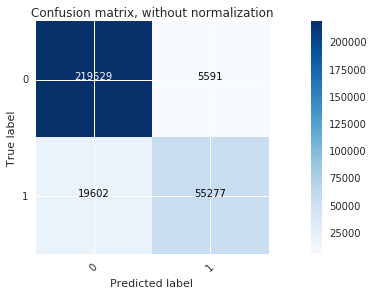

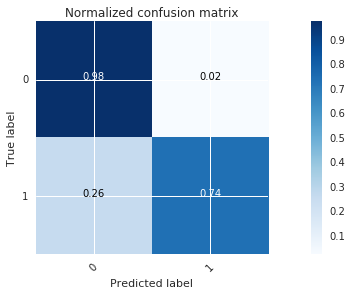

In [100]:
# Printing confusion matrix for model evaluation
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


class_names = np.unique(df.Y_PREMIUM_ANDROID)



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(sucess_metric_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [101]:
# Deciling customers based on predicted probability
decile = pd.DataFrame(
    {'prob': y_pred_prob,
     'prediction': y_pred,
     'actual': sucess_metric_test
    })
sort_for_decile = decile.sort_values('prob', ascending = False)
sort_for_decile['decile'] = pd.qcut(sort_for_decile['prob'], 10, labels=np.arange(10, 0, -1))
sort_for_decile

,actual,prediction,prob,decile
993733,1,1,0.999994,1
792659,1,1,0.999992,1
890484,1,1,0.999991,1
993253,1,1,0.999991,1
992063,1,1,0.999990,1
994464,1,1,0.999988,1
991991,1,1,0.999988,1
791005,1,1,0.999988,1
881108,1,1,0.999987,1
793092,1,1,0.999987,1


In [102]:
# Calculating actual conversions coverage by decile
decile_group=pd.DataFrame(sort_for_decile.groupby(['decile'])['actual'].sum())
decile_group['decile'] = decile_group.index
decile_group['count']=sort_for_decile.groupby(['decile'])['actual'].count()
decile_group['prediction']=sort_for_decile.groupby(['decile'])['prediction'].sum()
decile_group['per']=(decile_group['actual']/decile_group['actual'].sum())*100
decile_group = decile_group.sort_values(['decile'], ascending=[False ])
decile_group['per_random']=(decile_group['count']/decile_group['count'].sum())*100
decile_group['cum_sum_per_rand'] = decile_group.per_random.cumsum()
decile_group['cum_sum_per'] = decile_group.per.cumsum()
decile_group

,actual,decile,count,prediction,per,per_random,cum_sum_per_rand,cum_sum_per
decile,,,,,,,,
1,29995,1,30000,30000,40.057960,10.000033,10.000033,40.057960
2,24811,2,30000,30000,33.134791,10.000033,20.000067,73.192751
3,10747,3,30000,868,14.352489,10.000033,30.000100,87.545240
4,5928,4,30000,0,7.916772,10.000033,40.000133,95.462012
5,2411,5,29999,0,3.219861,9.999700,49.999833,98.681873
6,638,6,30000,0,0.852041,10.000033,59.999867,99.533915
7,235,7,30000,0,0.313840,10.000033,69.999900,99.847754
8,109,8,29998,0,0.145568,9.999367,79.999267,99.993323
9,5,9,30002,0,0.006677,10.000700,89.999967,100.000000


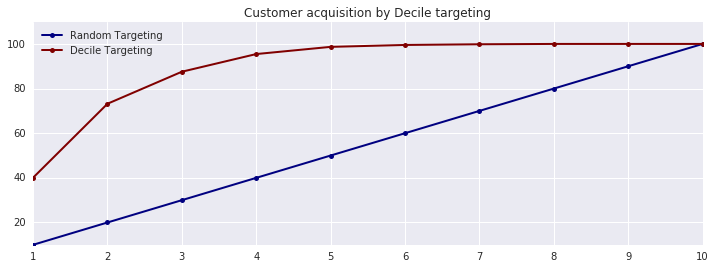

In [103]:
# Plotting conversion coverage by decile
import pandas as pd
values = np.array(decile_group.iloc[:,6:8])
df2 = pd.DataFrame(values, columns=['Random Targeting', 'Decile Targeting'], index=np.array(decile_group.iloc[:,1:2]))
df2.plot(lw=2,colormap='jet',marker='.',markersize=10,title='Customer acquisition by Decile targeting')
#['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10']

In [104]:
# Calculating impact of important features represented by odds
from sklearn.linear_model import LogisticRegression

# Important features list from XGBoost model
cols=Important_Metric_inorder['Attribute']
df_impact=train_dataset[cols]

# success metric
df_impact['Y_PREMIUM_ANDROID']=train_dataset['Y_PREMIUM_ANDROID']
df_impact_na=df_impact.dropna()
input_metrics = df_impact_na[cols]
sucess_metric = df_impact_na['Y_PREMIUM_ANDROID']
logistic = LogisticRegression()
logmodel=logistic.fit(input_metrics,sucess_metric)
coefficients = pd.concat([pd.DataFrame(df_impact_na[cols].columns),pd.DataFrame(np.transpose(logmodel.coef_))], axis = 1)
coefficients.columns=['Attribute','Coef']
coefficients['odds'] = np.exp(coefficients['Coef'])
coefficients.drop(['Coef'],axis=1, inplace=True)
coefficients_sort=coefficients.sort_values('odds', ascending = False)
result = pd.merge( Important_Metric_inorder, coefficients_sort ,how='left', left_on=['Attribute'], right_on = ['Attribute'])
result

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Importance,Attribute,odds
0,0.119186,PAST_2NDLINE_CONTRACT,4.244532
1,0.111919,PAST_POSTPAY_CONTRACTS,0.090591
2,0.103198,DIFF_CURRENT_PREV_PURCHASE,1.000575
3,0.074128,AVERAGE_TEC,0.996283
4,0.069767,CPW_STORE_PURCHASE_COUNT,1.715111
5,0.062500,PAST_RETAINED_CONTRACT,2.349419
6,0.046512,CPW_STORE_PURCHASE_FLAG,5.537209
7,0.043605,AVERAGE_TARIFF,1.094974
8,0.020349,PREV_ANDROID_OS_COUNT,1.012547
9,0.014535,PREV_APPLE_PHONE_COUNT,0.578144


In [105]:
import pickle
# save model to file
pickle.dump(unicode(model), open("proxy.dat", "wb"))